# Import Libs & Datasets

In [2]:
# Import Libs
import dowhy, os
import dowhy.datasets
import pandas as pd
import numpy as np
import graphviz
from graphviz import *
import matplotlib.pyplot as plt
import seaborn as sns
from dowhy import *
sns.set()
%matplotlib inline

In [3]:
# Import Dataset
train = pd.read_csv('./dataset/titanic/train.csv')

In [4]:
print('train data shape  |', train.shape)

train data shape  | (891, 12)


# Define Functions

In [5]:
# https://graphviz.readthedocs.io/en/stable/examples.html#process-py
def graphviz(t_, o_, cc_, ate, latent = True):
    g = Digraph('finite_state_machine', filename = f'{t_}_on_{o_}.gv')
    g.attr(size='10,10')

    g.attr('node', shape = 'Msquare', color = 'black')
    g.node(t_)
    g.node(o_)

    g.attr('node', shape = 'circle', color = 'black')
    for cc in cc_:
        g.edge(cc, t_)
        g.edge(cc, o_)
    
    g.edge(t_, o_, label = str(ate))

    if latent:
        g.attr('node', shape = 'circle', style = 'filled', color = 'black')
        g.edge('U', t_, color = 'lightgrey')
        g.edge('U', o_, color = 'lightgrey')
    
    return g  

In [6]:
def cm(data, t_, o_, cc_):
    model=CausalModel(
            data = data,
            treatment= t_,
            outcome= o_,
            common_causes= cc_)

    identified_estimand = model.identify_effect()
    estimate = model.estimate_effect(identified_estimand,
            method_name="backdoor.propensity_score_weighting",
            method_params={"weighting_scheme":"ips_weight"})
    return estimate.value

In [7]:
def analysis(data, t_, o_, cc_):
    score_ = cm(data, t_, o_, cc_)
    graphviz_ = graphviz(t_, o_, cc_, score_)
    print(f'ATE of Treatment \'{t_}\' on Outcome \'{o_}\'     |     {score_}')
    return graphviz_

## 1. Causal Estimand - T: Sex, O: Survived
### $\rightarrow$ Is more men died because of their gender?

In [8]:
titanic = train.copy()
# Preprocess Data -> Let female(str) be True(bool) and male(str) be False(bool)
for i in range(len(titanic.index)):
    if titanic['Sex'][i] == 'female':
        titanic['Sex'][i] = True
    else:
        titanic['Sex'][i] = False
titanic = titanic.astype({'Sex':'bool'}, copy = False)
titanic = titanic.dropna(axis=0)

In [9]:
# Set Treatment | Confounding Features | Outcome
treatment = 'Sex'
outcome = 'Survived'
common_causes = 'Pclass+Age+SibSp+Parch+Fare'.split('+')

INFO:dowhy.causal_graph:If this is observed data (not from a randomized experiment), there might always be missing confounders. Adding a node named "Unobserved Confounders" to reflect this.
INFO:dowhy.causal_model:Model to find the causal effect of treatment ['Sex'] on outcome ['Survived']
INFO:dowhy.causal_identifier:Common causes of treatment and outcome:['SibSp', 'Pclass', 'Parch', 'U', 'Age', 'Fare']
INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:[]
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: Survived~Sex+SibSp+Pclass+Parch+Age+Fare
ATE of Treatment 'Sex' on Outcome 'Survived'     |     0.4368972515130365


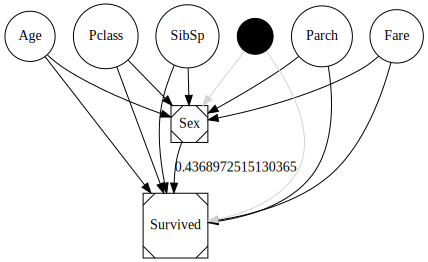

In [10]:
analysis(titanic, treatment, outcome, common_causes)

## 2. Causal Estimand - T: PClass, O: Survived
### $\rightarrow$ people died because of they are the passenger of low class?

In [11]:
titanic1 = train.copy()
for i in range(len(titanic1.index)):
    if titanic1['Pclass'][i] < 3:
        titanic1['Pclass'][i] = True
    else:
        titanic1['Pclass'][i] = False
titanic1 = titanic1.astype({'Pclass':'bool'}, copy = False)
titanic1 = titanic1.dropna(axis=0)

In [12]:
# Set Treatment | Confounding Features | Outcome
treatment = 'Pclass'
outcome = 'Survived'
common_causes = 'Sex+Age+SibSp+Parch+Fare'.split('+')

INFO:dowhy.causal_graph:If this is observed data (not from a randomized experiment), there might always be missing confounders. Adding a node named "Unobserved Confounders" to reflect this.
INFO:dowhy.causal_model:Model to find the causal effect of treatment ['Pclass'] on outcome ['Survived']
INFO:dowhy.causal_identifier:Common causes of treatment and outcome:['Parch', 'Sex', 'Age', 'U', 'Fare', 'SibSp']
INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:[]
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: Survived~Pclass+Parch+Sex+Age+Fare+SibSp
ATE of Treatment 'Pclass' on Outcome 'Survived'     |     0.6266013515193377


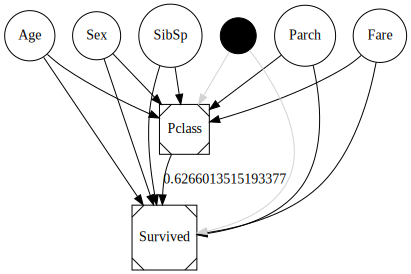

In [13]:
analysis(titanic1, treatment, outcome, common_causes)

## 3. Causal Estimand - T: Family(Parch + SibSp), O: Survived
### $\rightarrow$ Did the number of families cause the survival?

We make new feature labeled as 'Family', which is the sum of 'Parch' and 'Sibsp'

In [14]:
titanic2= train.copy()
titanic2['Parch'].mean()

In [15]:
titanic2['SibSp'].mean()

(array([678., 118.,   0.,  80.,   0.,   5.,   4.,   0.,   5.,   1.]),
 array([0. , 0.6, 1.2, 1.8, 2.4, 3. , 3.6, 4.2, 4.8, 5.4, 6. ]),
 <BarContainer object of 10 artists>)

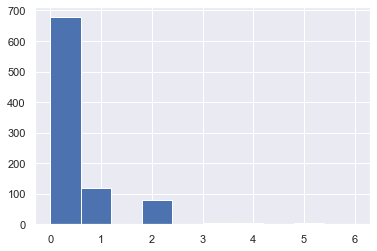

In [16]:
plt.hist(titanic2['Parch'])

(array([608., 209.,  28.,  16.,   0.,  18.,   5.,   0.,   0.,   7.]),
 array([0. , 0.8, 1.6, 2.4, 3.2, 4. , 4.8, 5.6, 6.4, 7.2, 8. ]),
 <BarContainer object of 10 artists>)

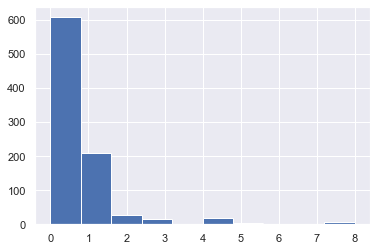

In [17]:
plt.hist(titanic2['SibSp'])

In [18]:
titanic2['Family'] = titanic2['SibSp'] + titanic2['Parch']

Calculated mean   |    0.90
Calculated median |    0.0


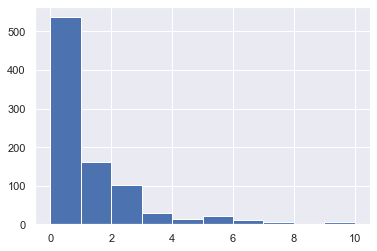

In [19]:
plt.hist(titanic2['Family'])
mean = titanic2['Family'].mean()
median = titanic2['Family'].median()
print(f'Calculated mean   |    {mean:.2f}')
print(f'Calculated median |    {median}')

Mean of 'Family' is 0.90 and median is 0.0.
To analyze causality, treatment variable must be boolean(True, False).
Data preprocessed to boolean True when the number of family is greater than/equal to 1, False, otherwise

In [20]:
for i in range(len(titanic2.index)):
    if titanic2['Family'][i] > 0:
        titanic2['Family'][i] = True
    else:
        titanic2['Family'][i] = False
titanic2 = titanic2.astype({'Family':'bool'}, copy = False)
titanic2 = titanic2.dropna(axis=0)

In [21]:
# Set Treatment | Confounding Features | Outcome
treatment = 'Family'
outcome = 'Survived'
common_causes = 'Sex+Age+Pclass+Fare'.split('+')

INFO:dowhy.causal_graph:If this is observed data (not from a randomized experiment), there might always be missing confounders. Adding a node named "Unobserved Confounders" to reflect this.
INFO:dowhy.causal_model:Model to find the causal effect of treatment ['Family'] on outcome ['Survived']
INFO:dowhy.causal_identifier:Common causes of treatment and outcome:['Pclass', 'Sex', 'U', 'Age', 'Fare']
INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:[]
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: Survived~Family+Pclass+Sex+Age+Fare
ATE of Treatment 'Family' on Outcome 'Survived'     |     -0.13672603443632347


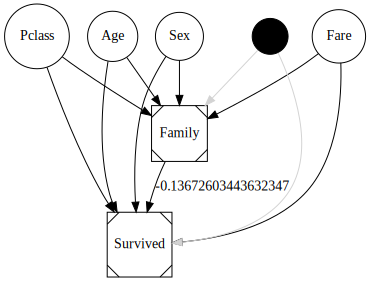

In [22]:
analysis(titanic2, treatment, outcome, common_causes)